In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon


from nbhd import data, geography, geometry

In [1]:
db = data.Base()

x_min, x_max, y_min, y_max = 336097, 339909, 390882, 393101

box = Polygon([(x_min, y_min),
               (x_min, y_max),
               (x_max, y_max),
               (x_max, y_min),
               (x_min, y_min)])

Initializing database connection...
Database connected!


In [2]:
settings = {'footprint_threshold':250,
            'res_length_threshold':30,
            'short_threshold':10,
            'min_community_size':10,
            'node_distance':5}

In [4]:
df, subgraphs = geography.get_communities(db, box, **settings)

Starting to find neighbourhoods in polygon centred at POINT (338003 391991.5)
Collected 37583 properties...
... of which 34364 are in buildings
Getting streets...
Snapping nodes...
Finding connected graphs...
Labelling communities.


In [5]:
df.community.value_counts()

05    15177
01     5870
04     3395
02     1957
08     1199
03     1025
06      892
07      590
10      305
09      296
12      248
13      151
11      143
Name: community, dtype: int64

In [8]:
select = '13'


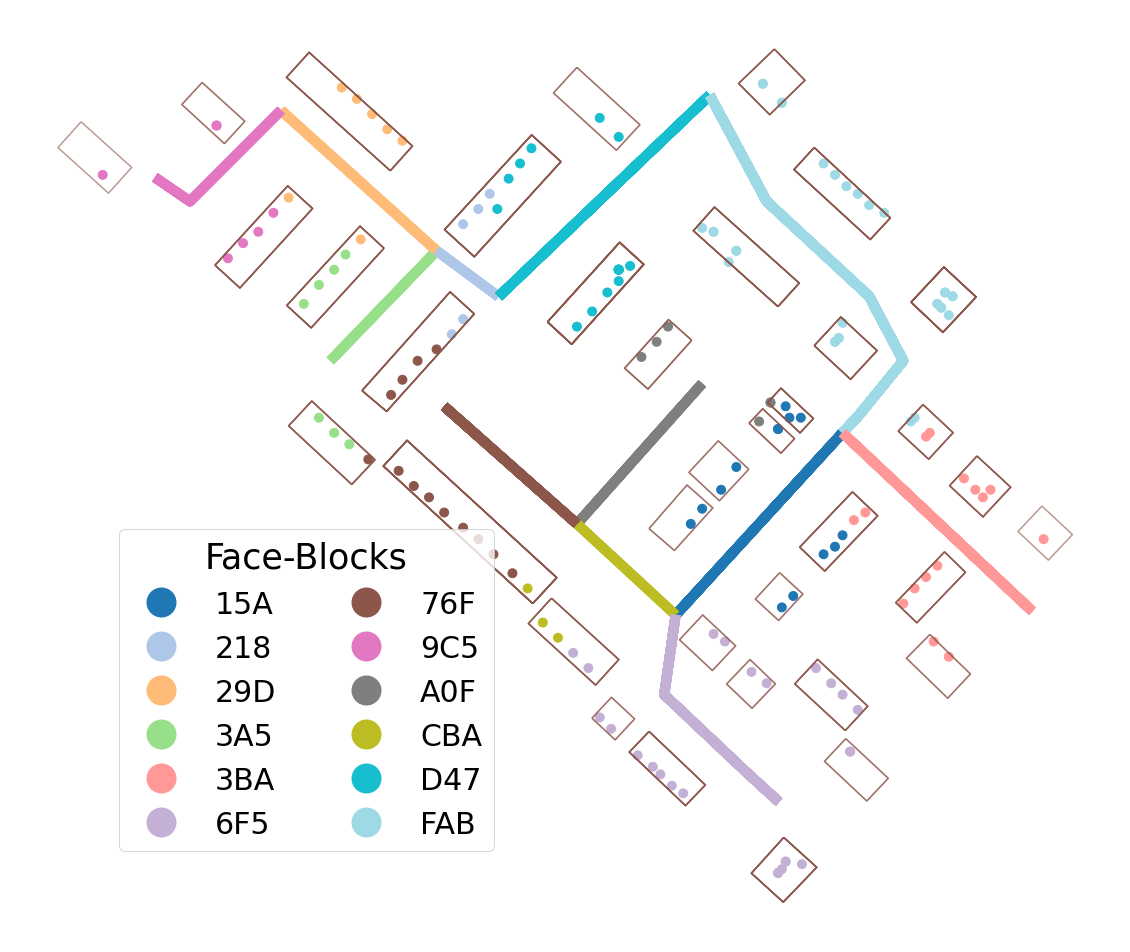

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
cmap = 'tab20'

df['short_road_id'] = df.roads_id.str.slice(2,5)
gpd.GeoDataFrame(df.loc[df.community==select],geometry=gpd.GeoSeries.from_wkb(
    df.roads_geometry)).plot('short_road_id', ax=ax, linewidth=10, legend=True, 
                              legend_kwds={'fontsize':30, 
                        'markerscale':3,
                        'loc':(0.1,0.1),#'best',
                        'title': 'Face-Blocks',
                        'title_fontsize':35,
                        'markerfirst': True,
                        'ncol':2}, cmap=cmap )

buildings = gpd.GeoDataFrame(df[['buildings_id','community']],
                             geometry=gpd.GeoSeries.from_wkb(df.buildings_geometry))
buildings.loc[buildings.community==select].boundary.plot(ax=ax, alpha=0.6, color='tab:brown')

gpd.GeoDataFrame(df.loc[df.community==select],
                 geometry=gpd.GeoSeries.from_wkb(
                     df.properties_geometry)).plot('short_road_id', ax=ax, markersize=80 ,alpha=1.0,
                                                  cmap=cmap)
ax.set_axis_off()
ax.figure.savefig('../fig/single_community.png',
                  bbox_inches='tight',
                 transparent=False, pad_inches=0)

In [13]:
from nbhd.geography import FaceBlock

In [14]:
selected = df.loc[df.community==select]

<AxesSubplot:>

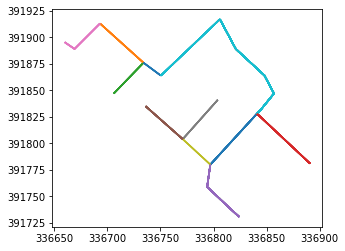

In [17]:
selected.plot('short_road_id')

In [18]:
selected_rds = selected.loc[~selected.roads_id.duplicated()]

In [26]:
from shapely.geometry import MultiLineString

In [27]:
network = MultiLineString(list(selected_rds.geometry.values))

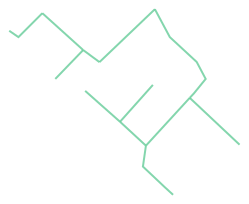

In [29]:
network

In [32]:
nearby_rds = db.intersects('roads', network.buffer(100))

<AxesSubplot:>

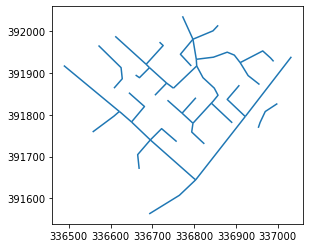

In [34]:
near.plot() # TODO: investigate why nodes don't snap or short road didn't connect or whatever is making this a separate network.

In [35]:
# faceblock stats

In [36]:
faceblocks = selected_rds.roads_id.apply(lambda x: FaceBlock(df, x, db))

FaceBlock: id3BA0FAB1-0713-486E-B4DF-F343CB8AA6DE
Finding neighbours...
{'start': ['idFAB4A315-FA22-4408-AE94-C0DC47B2BD88', 'id15A37B14-3965-4807-BE68-C6B5AF615048'], 'end': []}
FaceBlock: idFAB4A315-FA22-4408-AE94-C0DC47B2BD88
Finding neighbours...
{'start': ['id3BA0FAB1-0713-486E-B4DF-F343CB8AA6DE', 'id15A37B14-3965-4807-BE68-C6B5AF615048'], 'end': ['idD47DEF5C-08E4-4CF9-9AEE-5030A4A31D98']}
FaceBlock: id9C5D962A-1F9D-4A8C-8286-1E8CF80DB42E
Finding neighbours...
{'start': [], 'end': ['id29D448CF-DFC9-46B9-B4B2-F620245EAF53']}
FaceBlock: id29D448CF-DFC9-46B9-B4B2-F620245EAF53
Finding neighbours...
{'start': ['id3A5FE5FF-FD8B-462B-AA66-FBFF0022C4CA', 'id2183726E-DAEF-4EBC-9A6A-2E9FDF3A30E9'], 'end': ['id9C5D962A-1F9D-4A8C-8286-1E8CF80DB42E']}
FaceBlock: id15A37B14-3965-4807-BE68-C6B5AF615048
Finding neighbours...
{'start': ['idCBAB027B-F0EC-4F07-BCAE-0B734EC79F14', 'id6F530DBE-9200-439C-A710-A7D87DA84471'], 'end': ['id3BA0FAB1-0713-486E-B4DF-F343CB8AA6DE', 'idFAB4A315-FA22-4408-AE94-C

In [39]:
faceblocks.apply(lambda x: x.stats())

13241    None
13250    None
15634    None
21032    None
21932    None
21939    None
21952    None
23754    None
23757    None
23775    None
23797    None
23812    None
Name: roads_id, dtype: object

In [41]:
faceblocks

13241      Montgomery Way (Local Road): 15 properties.
13250         Conwy Drive (Local Road): 32 properties.
15634           Opal Close (Local Road): 7 properties.
21032    White Rock Street (Local Road): 7 properties.
21932         Conwy Drive (Local Road): 14 properties.
21939    White Rock Street (Local Road): 6 properties.
21952         Conwy Drive (Local Road): 25 properties.
23754            Pearl Way (Local Road): 7 properties.
23757         Cameo Close (Local Road): 13 properties.
23775    White Rock Street (Local Road): 5 properties.
23797           Jade Road (Local Road): 17 properties.
23812          Cameo Close (Local Road): 3 properties.
Name: roads_id, dtype: object

In [42]:
blocks_stats = faceblocks.apply(lambda x: x.stats_df.T.statistics).T

In [44]:
blocks_stats['mean'] = blocks_stats.apply(lambda x: getattr(x,'mean')(), axis=1)
blocks_stats['median'] = blocks_stats.apply(lambda x: getattr(x,'median')(), axis=1)
blocks_stats['std'] = blocks_stats.apply(lambda x:getattr(x,'std')(), axis=1)
blocks_stats['Q1'] = blocks_stats.apply(lambda x: x.quantile(0.25), axis=1)
blocks_stats['Q3'] = blocks_stats.apply(lambda x: x.quantile(0.75), axis=1)
blocks_stats['IQR'] = blocks_stats.apply(lambda x: x.Q3 - x.Q1, axis=1)

In [46]:
blocks_stats[['mean','std','Q1','median', 'Q3', 'IQR']].to_csv('../csv/fbs_summary.csv',
                                                              float_format='%.1f')

In [47]:
fb_df = pd.DataFrame(faceblocks)

In [50]:
fb_df.columns = ['FaceBlocks']

In [51]:
fb_df

,FaceBlocks
13241,Montgomery Way (Local Road): 15 properties.
13250,Conwy Drive (Local Road): 32 properties.
15634,Opal Close (Local Road): 7 properties.
21032,White Rock Street (Local Road): 7 properties.
21932,Conwy Drive (Local Road): 14 properties.
21939,White Rock Street (Local Road): 6 properties.
21952,Conwy Drive (Local Road): 25 properties.
23754,Pearl Way (Local Road): 7 properties.
23757,Cameo Close (Local Road): 13 properties.
23775,White Rock Street (Local Road): 5 properties.


In [52]:
for k in fb_df.values[0][0].count.keys():
    fb_df[k] = fb_df.apply(lambda x: x.FaceBlocks.count[k], axis=1)

In [53]:
fb_df['Road Name (Function)'] = fb_df.apply(lambda x: f'{x.FaceBlocks.road_name} ({x.FaceBlocks.road_function})', axis=1)

In [55]:
fb_df['id'] = fb_df.apply(lambda x: x.FaceBlocks.id[2:5], axis=1)

In [56]:
stats = fb_df[['id','Road Name (Function)', 'properties', 'buildings', 'neighbouring_face_blocks',
               'segment_length', 'block_building_footprint']]

In [57]:
stats.sort_values('Road Name (Function)').to_csv('../csv/faceblocks.csv', 
                                                 float_format='%.1f', index=None)

In [58]:
stats

,id,Road Name (Function),properties,buildings,neighbouring_face_blocks,segment_length,block_building_footprint
13241,3BA,Montgomery Way (Local Road),15,6,2,68.622154,451.143788
13250,FAB,Conwy Drive (Local Road),32,6,3,112.646909,872.786550
15634,9C5,Opal Close (Local Road),7,3,1,45.155317,316.477163
21032,29D,White Rock Street (Local Road),7,3,3,55.226805,369.850825
21932,15A,Conwy Drive (Local Road),14,6,4,65.115282,526.510733
21939,A0F,White Rock Street (Local Road),6,3,2,49.578221,186.405867
21952,6F5,Conwy Drive (Local Road),25,8,2,62.659106,816.878566
23754,3A5,Pearl Way (Local Road),7,2,2,40.311289,349.302620
23757,76F,Cameo Close (Local Road),13,3,2,46.754679,688.640589
23775,218,White Rock Street (Local Road),5,2,3,20.346371,252.148429
